# OBJECTIF

- Wavelet:
    - trouver une famille d'ondelettes sur laquelle décomposer les ECG
    - paramètres:
        - level
        - famille + numéro
        - threshold coefficients
    - critères:
        - SNR (comparaison ECG original - ECG reconstruit)
        - PCA (sur les ECG de tous les patients)

In [2]:
import h5py
import pywt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
import get_ecg
import utils.load as ul
import utils.illustration as uil

In [4]:
LEN=4096
NB_PATIENT=827
TRACINGS_FILE="./data/ecg_tracings.hdf5"

# Données

Test pour patient non malade

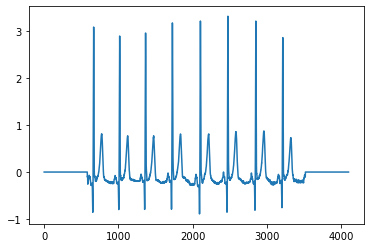

In [5]:
ecg_example=get_ecg.get_ecg()[0]
plt.plot(ecg_example)

In [6]:
with h5py.File(TRACINGS_FILE, "r") as f:
    table_ecg = np.array(f['tracings'])

# 1.  Décomposition Wavelet

In [12]:
pywt.families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

Nous étudierons la décomposition des signaux ECG au travers de 2 familles d'ondelette :
- Daubechies : 4, 5, 6, 7
- Symlets : 5, 6, 7, 8

avec plusieurs niveaux de décomposition.

## Exemple : db5

[ 0.          0.22641898  0.85394354  1.02432694  0.19576696 -0.34265672
 -0.04560113  0.10970266 -0.0088268  -0.01779187  0.00471743  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[ 0.          0.00471743  0.01779187 -0.0088268  -0.10970266 -0.04560113
  0.34265672  0.19576696 -1.02432694  0.85394354 -0.22641898  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5
 9. ]


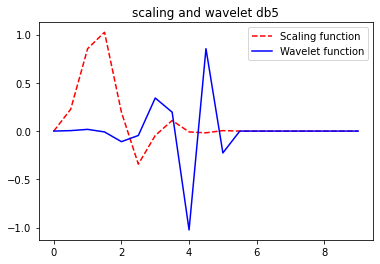

In [13]:
wavelet = pywt.Wavelet('db5')
phi, psi, x = wavelet.wavefun(level=1)
print (phi)
print(psi)
print(x)
p1,=plt.plot(x,phi,'r--')
p2,=plt.plot(x,psi,'b-')
plt.title("scaling and wavelet db5")
plt.legend([p1, p2], ['Scaling function', 'Wavelet function'])
plt.show()

### Level

In [14]:
print("niveau maximal de décomposition")
w = pywt.Wavelet('db5')
pywt.dwt_max_level(4096, w)

niveau maximal de décomposition


8

### Single-level decomposition

In [15]:
cA, cD = pywt.dwt(ecg_example, 'db5')

#  Approximation (or scale) coefficients 
print(cA)
# Detail (or wavelets) coefficients
print(cD)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


### Multi-level decomposition

In [16]:
coeffs = pywt.wavedec(ecg_example, 'db5',level=3)

cA3, cD3, cD2 , cD1 = coeffs

print("cA3",cA3)
print("cD3",cD3)
print("cD2",cD2)
print("cD1",cD1)

cA3 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.0

### Thresholding (pour méthode d'approximation  non linéaire)

In [17]:
sigma=1

thresh = sigma*np.sqrt(2*np.log(LEN))

sigma =  1
Number of non-zero coefficients before =  2944
Number of non-zero coefficients after =  1472


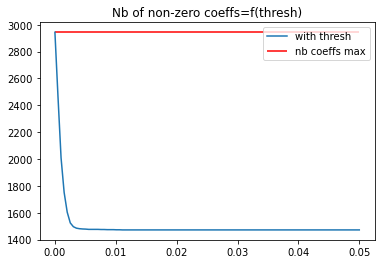

In [18]:
#single-level
cDth=pywt.threshold(cD, thresh, 'hard')

nbcoef1=sum(cA!=0)+sum(cD!=0)
nbcoef2=sum(cA!=0)+sum(cDth!=0)

print('sigma = ', 1)
print ('Number of non-zero coefficients before = ', nbcoef1)
print ('Number of non-zero coefficients after = ', nbcoef2)

def test_threshold_single_level(ecg,sigma_min=0, sigma_max=0.05, family='db5'):
    cA,cD = pywt.dwt(ecg, family)
    plt.hlines(sum(cA!=0)+sum(cD!=0),sigma_min, sigma_max, label='nb coeffs max', color='red')
    
    sigma_space=np.linspace(sigma_min,sigma_max,100)
    nbcoef_after=[]
    
    for sigma in sigma_space:
        thresh = sigma*np.sqrt(2*np.log(LEN))
        cA,cD = pywt.dwt(ecg, family)
        
        cDth=pywt.threshold(cD, thresh, 'hard')
        nbcoef_after.append(sum(cA!=0)+sum(cDth!=0))
    plt.plot(sigma_space,nbcoef_after, label='with thresh')
    plt.title("Nb of non-zero coeffs=f(thresh)")
    plt.legend()
    plt.show()

test_threshold_single_level(ecg_example)
        
    

sigma =  1
Number of non-zero coefficients before =  2962
Number of non-zero coefficients after =  375


C:\Users\maxen\Anaconda3\lib\site-packages\pywt\_thresholding.py:23: RuntimeWarning: invalid value encountered in true_divide
  thresholded = (1 - value/magnitude)


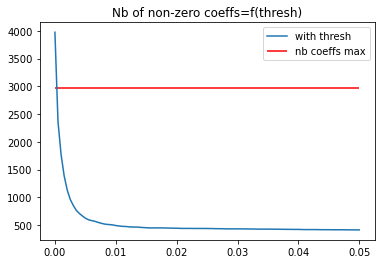

In [19]:
#multi-level

cD3th=pywt.threshold(cD3, thresh, 'soft')
cD2th=pywt.threshold(cD2, thresh, 'soft')
cD1th=pywt.threshold(cD1, thresh, 'soft')

coeffsth= cA3, cD3th, cD2th , cD1th

nbcoef1=sum(cA3!=0)+sum(cD3!=0)+sum(cD2!=0)+sum(cD1!=0)
nbcoef2=sum(cA3!=0)+sum(cD3th!=0)+sum(cD2th!=0)+sum(cD1th!=0)
print('sigma = ', 1)
print ('Number of non-zero coefficients before = ', nbcoef1)
print ('Number of non-zero coefficients after = ', nbcoef2)


def test_threshold_multi_level(ecg,sigma_min=0, sigma_max=0.05,level=3, family='db5'):
    coeffs = pywt.wavedec(ecg, family,level=level)
    nb_coeffs_non_zero=np.sum([sum(x!=0) for x in coeffs])
    plt.hlines(nb_coeffs_non_zero,sigma_min, sigma_max, label='nb coeffs max', color='red')
    
    sigma_space=np.linspace(sigma_min,sigma_max,100)
    nbcoef_after=[]
    
    for sigma in sigma_space:
        thresh = sigma*np.sqrt(2*np.log(LEN))
        coeffs = pywt.wavedec(ecg, family,level=level)
        new_coeffs=[pywt.threshold(c, thresh, 'soft') for c in coeffs[1:]]
        nbcoef_after.append(sum(coeffs[0]!=0) + np.sum([sum(x!=0) for x in new_coeffs]))

    plt.plot(sigma_space,nbcoef_after, label='with thresh')
    plt.title("Nb of non-zero coeffs=f(thresh)")
    plt.legend()
    plt.show()

test_threshold_multi_level(ecg_example)

### Reconstruction

longueur du nouveau signal 4112


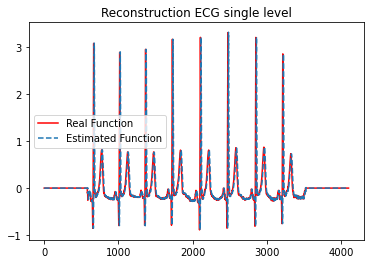

In [20]:
# single-level
single_level_ecg_rec= pywt.upcoef('a', cA, 'db5') + pywt.upcoef('d', cDth, 'db5')

print("longueur du nouveau signal",len(single_level_ecg_rec))

plt.plot(ecg_example,'red',label="Real Function")
plt.plot(single_level_ecg_rec[:LEN],'--',label="Estimated Function")
plt.title("Reconstruction ECG single level")
plt.legend()
plt.show()

longueur du nouveau signal 4096


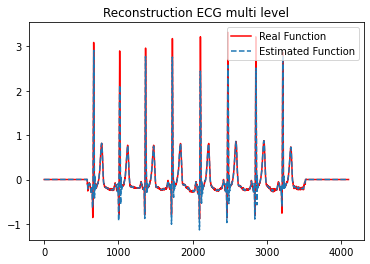

In [21]:
#multi-level

coeffsth= cA3, cD3th, cD2th , cD1th
multi_level_ecg_rec=pywt.waverec(coeffsth, 'db5')
print("longueur du nouveau signal",len(multi_level_ecg_rec))

plt.plot(ecg_example,'red',label="Real Function")
plt.plot(multi_level_ecg_rec,'--',label="Estimated Function")
plt.title("Reconstruction ECG multi level")
plt.legend()
plt.show()

### Critère de qualité : erreur quadratique

In [22]:
#single-level

single_level_error=np.mean((ecg_example-single_level_ecg_rec[:LEN])*(ecg_example-single_level_ecg_rec[:LEN]))
print("single_level_error = ",single_level_error)

single_level_error =  0.23732065873327146


In [23]:
#multi-level

multi_level_error=np.mean((ecg_example-multi_level_ecg_rec[:LEN])*(ecg_example-multi_level_ecg_rec[:LEN]))
print("multi_level_error = ", multi_level_error)

multi_level_error =  0.010065456248042092


## Général

In [7]:
def get_coeff_multi_level(ecg,sigma_threshold=1,type_threshold='soft',family='db5', level=5):
    coeffs = pywt.wavedec(ecg, family,level=level)
    thresh = sigma*np.sqrt(2*np.log(LEN))
    for i in range(1,len(coeffs)):
        coeffs[i]=pywt.threshold(coeffs[i], thresh, type_threshold)
    return coeffs

def reconstruct_signal(coeffsth,family='db5'):
    return pywt.waverec(coeffsth, family)

def error(real_ecg,rec_ecg):
    return np.mean((real_ecg-rec_ecg)*(real_ecg-rec_ecg))

## TEST (avec ECG0 du patient 0)

In [14]:
FAMILY_TO_TEST=['db4','db5','db6','db7','sym5','sym6','sym7','sym8']
LEVEL_TO_TEST=np.arange(2,9)
sigma=1

def test_general(ecg,sigma_threshold):

    f, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(20,25))

    for family in tqdm(FAMILY_TO_TEST):
        for type_threshold in ['soft','hard']:
            get_coeffs=[get_coeff_multi_level(ecg,sigma_threshold,type_threshold,family, level) for level in LEVEL_TO_TEST]
            new_signals=[reconstruct_signal(coeffsth,family) for coeffsth in get_coeffs]
            
            error_list=[error(ecg,rec_ecg) for rec_ecg in new_signals]
            ax1.plot(LEVEL_TO_TEST,error_list, label=family + " " +type_threshold)

            count_coeffs_non_zero=[np.sum([sum(abs(c)>0.0001) for c in coeffs]) for coeffs in get_coeffs]
            ax2.plot(LEVEL_TO_TEST,count_coeffs_non_zero, label=family + " " +type_threshold)

    ax1.set_title("Error = f(level) : sigma = "+str(sigma_threshold))
    ax1.legend(loc="best")
    ax2.set_title("Nb non zero coeffs = f(level) : sigma =  "+str(sigma_threshold))
    ax2.legend(loc="best")

    plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.40it/s]


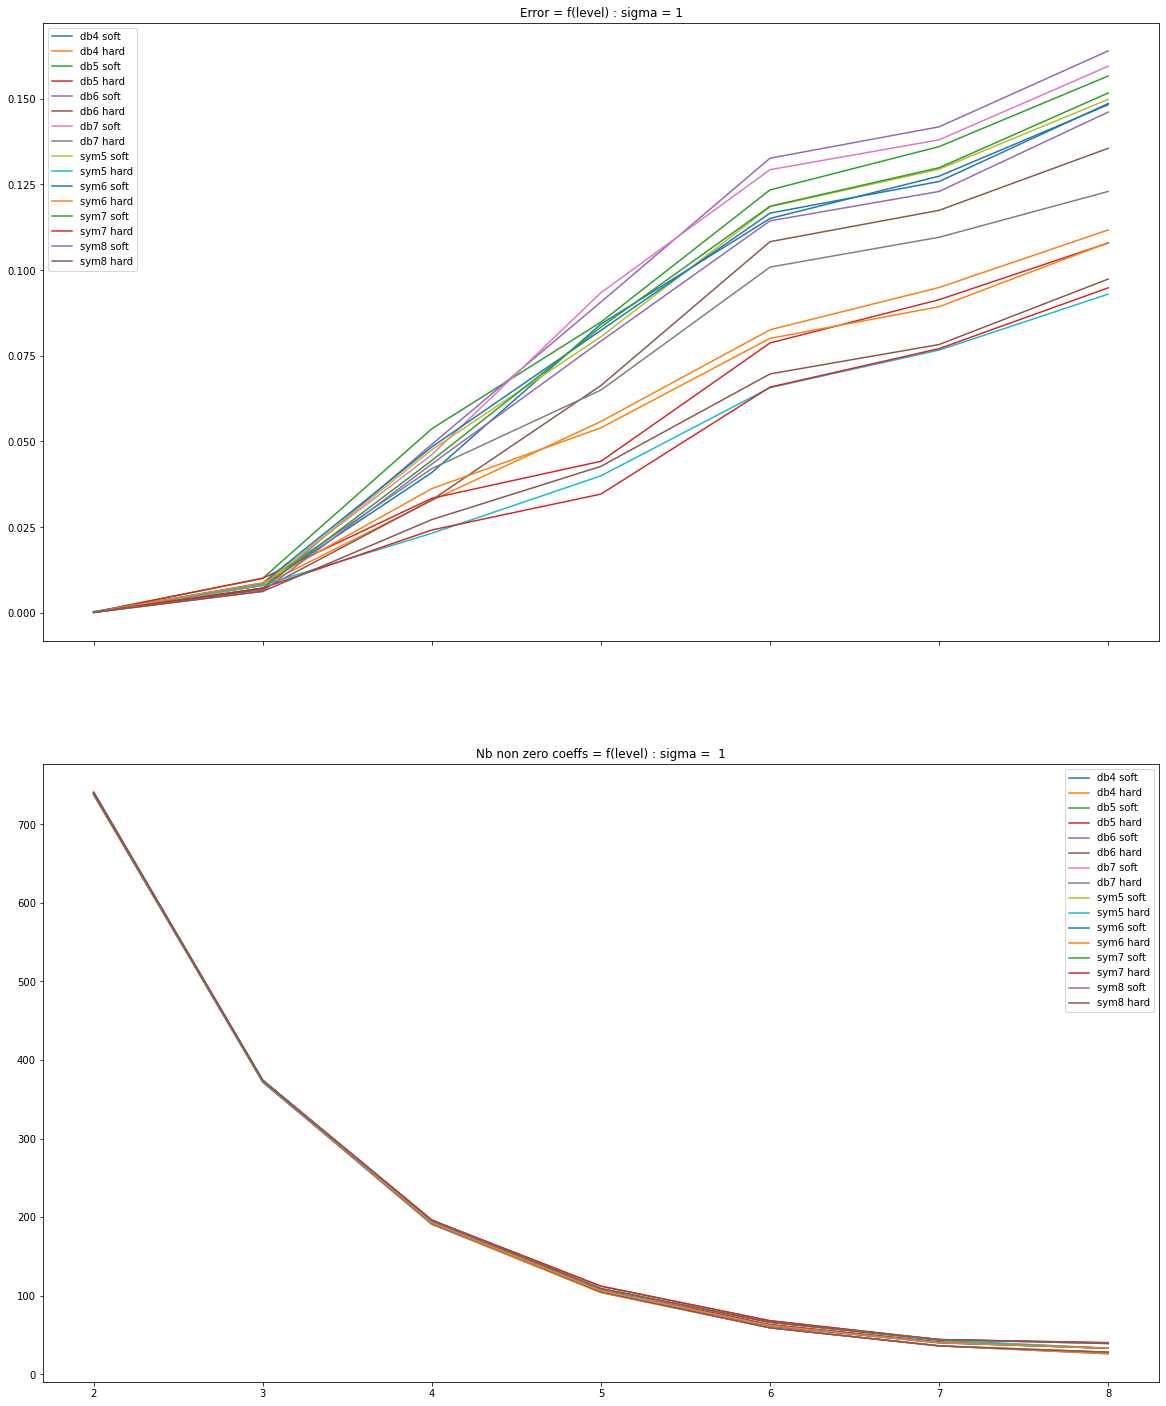

In [15]:
test_general(ecg_example,1)

## Explicabilité

Pour un faible niveau : 
- moins grand nombre de coeffs mais de grande valeur, donc peu de coeffs non nuls avec le threshold
- on garde plus de coeffs donc meilleur erreur quadratique

Pas de grande différence dans le nb de coeffs non nuls, donc on privilégie l'erreur quadratique.

BEST TRADEOFF

Level = 5
- 100 coefficients non nuls
- erreur inférieure à 0.050
- sym8 hard
- sym7 hard
- db5 hard
- db6 hard


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.60it/s]


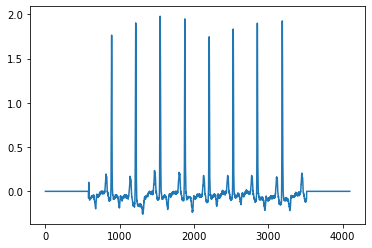

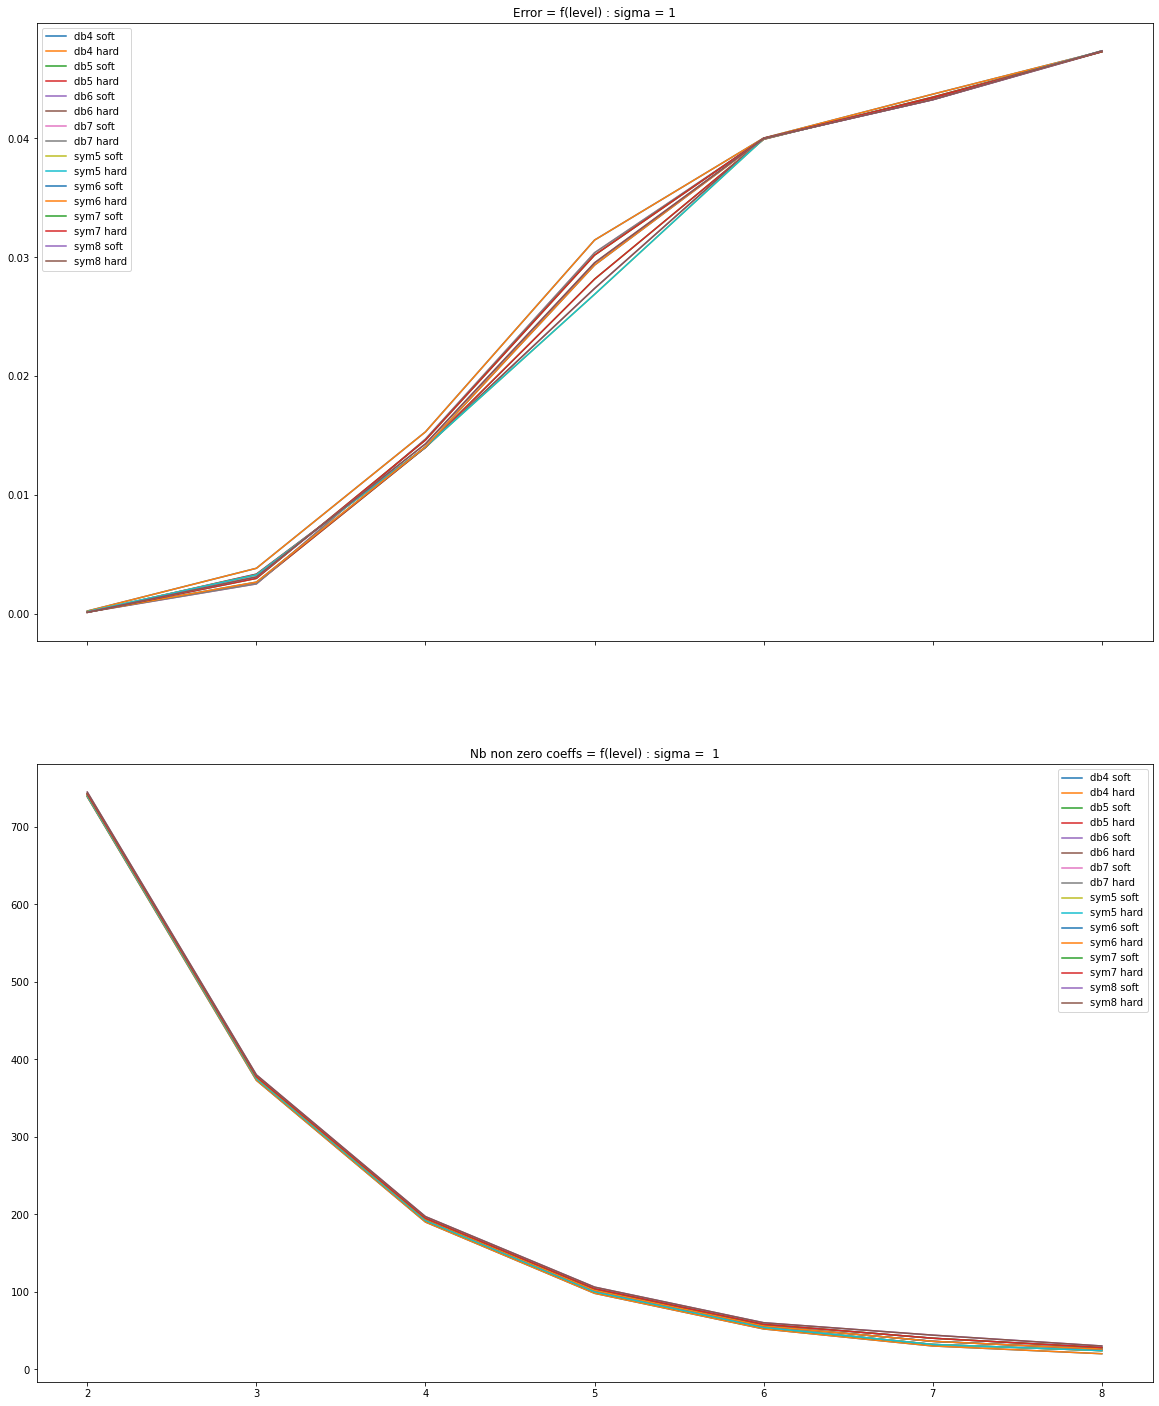

In [138]:
ecg_example1=get_ecg.get_ecg(patient_id=12)[0]
plt.plot(ecg_example1)

test_general(ecg_example1,1)

## TEST des 3 familles sur tous les ECG, level=8, soft, sigma=1 : erreur

In [41]:
def distribution_error_and_count_zero(type_ecg,family, level, type_thre,sigma):
    error_range=[]
    nb_non_zero=[]
    for patient_id in tqdm(range(NB_PATIENT)):
        ecg=table_ecg[patient_id,:,type_ecg]
        coeffs=get_coeff_multi_level(ecg,sigma,type_thre,family,level=level)
        count_coeffs_non_zero=np.sum([sum(abs(c)>0.0001) for c in coeffs])
        error_signal=error(ecg,reconstruct_signal(coeffs, family))
        nb_non_zero.append(count_coeffs_non_zero)
        error_range.append(error_signal)
    return error_range, nb_non_zero

Daubechy 5 and 6 : Hard or soft threshold ? Error closer to 0 with hard, with the same number of non zero coeffs

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 107.03it/s]


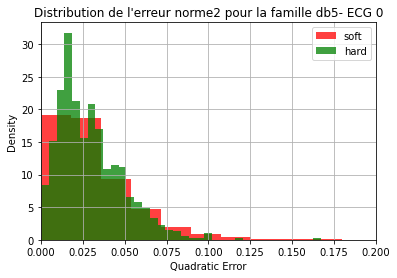

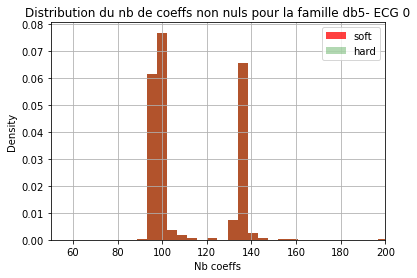

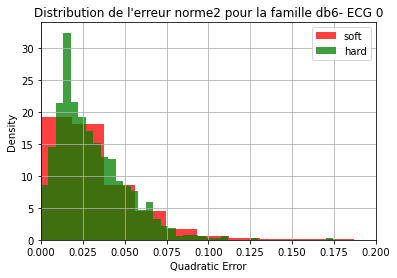

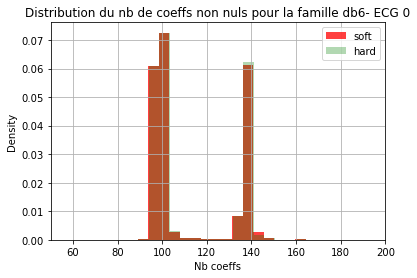

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 104.50it/s]


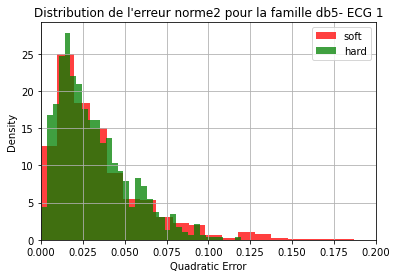

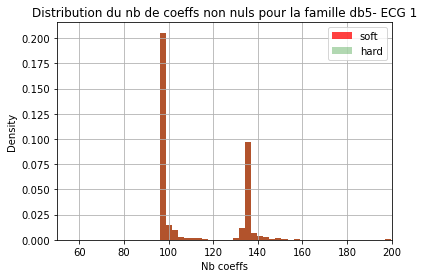

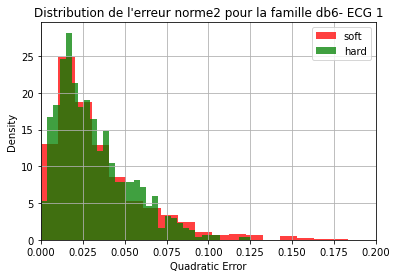

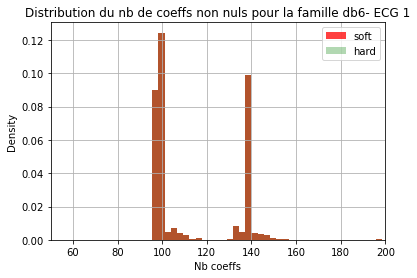

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 105.14it/s]


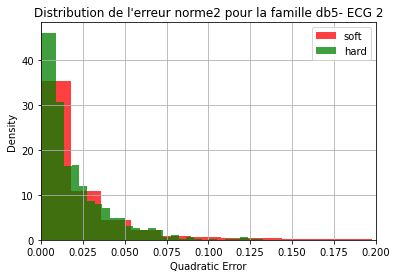

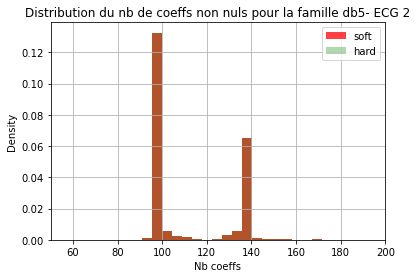

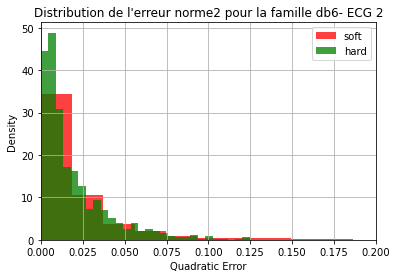

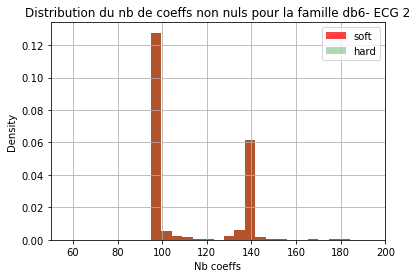

In [77]:
for TYPE_ECG in range(3):

    error_db5, nb_non_zero_db5=distribution_error_and_count_zero(TYPE_ECG,'db5',5,'hard',1)
    error_db5_soft, nb_non_zero_db5_soft=distribution_error_and_count_zero(TYPE_ECG,'db5',5,'soft',1)
    error_db6, nb_non_zero_db6=distribution_error_and_count_zero(TYPE_ECG,'db6',5,'hard',1)
    error_db6_soft, nb_non_zero_db6_soft=distribution_error_and_count_zero(TYPE_ECG,'db6',5,'soft',1)
    
    #db5
    n2, bins2, patches2 = plt.hist(error_db5_soft, bins=100,density=True, facecolor='r', alpha=0.75, label='soft')
    n, bins, patches = plt.hist(error_db5, bins=100,density=True, facecolor='g', alpha=0.75, label='hard')

    plt.xlabel('Quadratic Error')
    plt.ylabel('Density')
    plt.title("Distribution de l'erreur norme2 pour la famille db5- ECG "+str(TYPE_ECG))
    plt.xlim(0, 0.2)
    plt.legend()
    plt.grid(True)
    plt.show()

    n2, bins2, patches2 = plt.hist(nb_non_zero_db5_soft, bins=100,density=True, facecolor='r', alpha=0.75, label='soft')
    n, bins, patches = plt.hist(nb_non_zero_db5, bins=100,density=True, facecolor='g', alpha=0.3, label='hard')

    plt.xlabel('Nb coeffs')
    plt.ylabel('Density')
    plt.title("Distribution du nb de coeffs non nuls pour la famille db5- ECG "+str(TYPE_ECG))
    plt.xlim(50, 200)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    #db6
    n2, bins2, patches2 = plt.hist(error_db6_soft, bins=100,density=True, facecolor='r', alpha=0.75, label='soft')
    n, bins, patches = plt.hist(error_db6, bins=100,density=True, facecolor='g', alpha=0.75, label='hard')

    plt.xlabel('Quadratic Error')
    plt.ylabel('Density')
    plt.title("Distribution de l'erreur norme2 pour la famille db6- ECG "+str(TYPE_ECG))
    plt.xlim(0, 0.2)
    plt.legend()
    plt.grid(True)
    plt.show()

    n2, bins2, patches2 = plt.hist(nb_non_zero_db6_soft, bins=100,density=True, facecolor='r', alpha=0.75, label='soft')
    n, bins, patches = plt.hist(nb_non_zero_db6, bins=100,density=True, facecolor='g', alpha=0.3, label='hard')

    plt.xlabel('Nb coeffs')
    plt.ylabel('Density')
    plt.title("Distribution du nb de coeffs non nuls pour la famille db6- ECG "+str(TYPE_ECG))
    plt.xlim(50, 200)
    plt.legend()
    plt.grid(True)
    plt.show()

Symlet : Hard or soft threshold ? Error closer to 0, with the same number of non zero coeffs

100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [00:08<00:00, 98.11it/s]


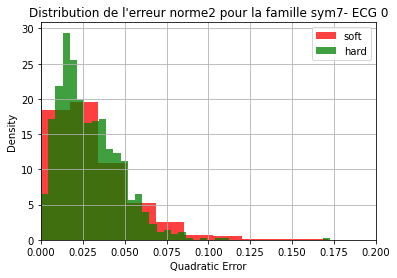

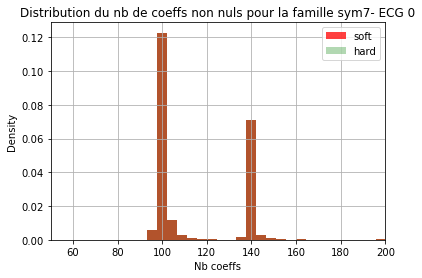

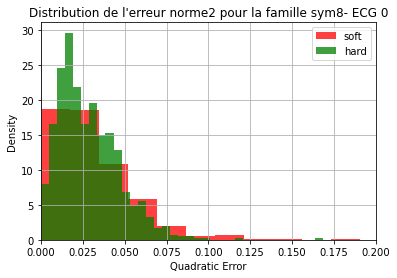

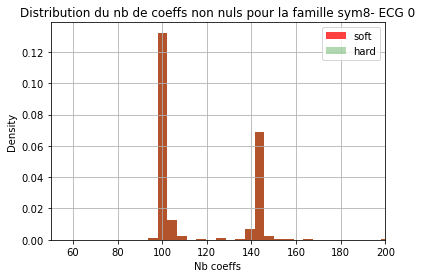

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:08<00:00, 101.44it/s]


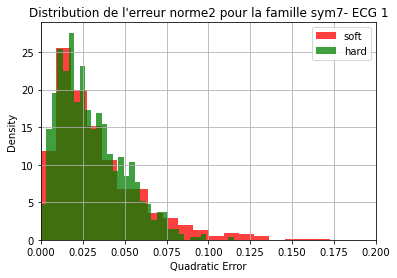

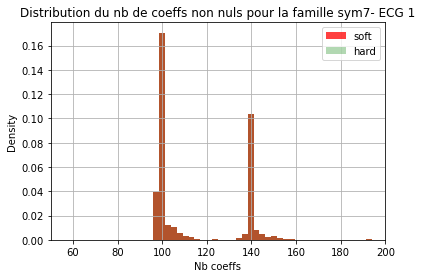

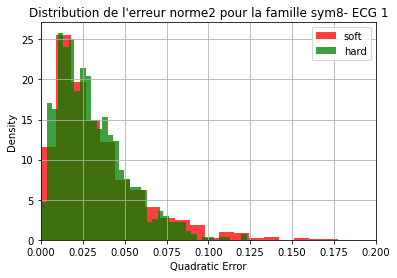

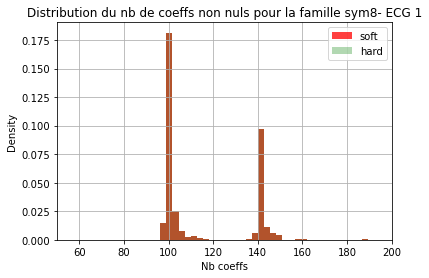

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 105.93it/s]


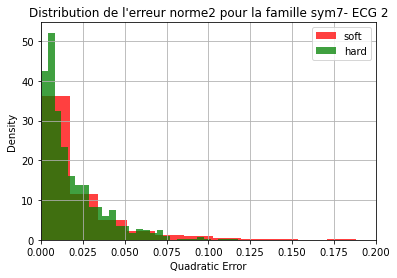

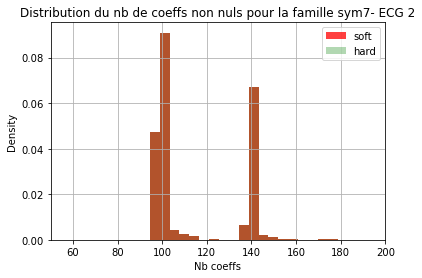

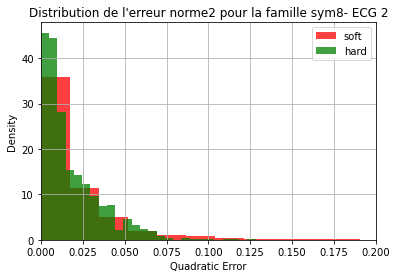

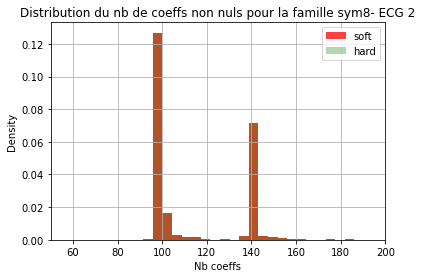

In [79]:
for TYPE_ECG in range(3):

    error_sym7, nb_non_zero_sym7=distribution_error_and_count_zero(TYPE_ECG,'sym7',5,'hard',1)
    error_sym7_soft, nb_non_zero_sym7_soft=distribution_error_and_count_zero(TYPE_ECG,'sym7',5,'soft',1)
    error_sym8, nb_non_zero_sym8=distribution_error_and_count_zero(TYPE_ECG,'sym8',5,'hard',1)
    error_sym8_soft, nb_non_zero_sym8_soft=distribution_error_and_count_zero(TYPE_ECG,'sym8',5,'soft',1)
    
    #sym7
    n2, bins2, patches2 = plt.hist(error_sym7_soft, bins=100,density=True, facecolor='r', alpha=0.75, label='soft')
    n, bins, patches = plt.hist(error_sym7, bins=100,density=True, facecolor='g', alpha=0.75, label='hard')

    plt.xlabel('Quadratic Error')
    plt.ylabel('Density')
    plt.title("Distribution de l'erreur norme2 pour la famille sym7- ECG "+str(TYPE_ECG))
    plt.xlim(0, 0.2)
    plt.legend()
    plt.grid(True)
    plt.show()

    n2, bins2, patches2 = plt.hist(nb_non_zero_sym7_soft, bins=100,density=True, facecolor='r', alpha=0.75, label='soft')
    n, bins, patches = plt.hist(nb_non_zero_sym7, bins=100,density=True, facecolor='g', alpha=0.3, label='hard')

    plt.xlabel('Nb coeffs')
    plt.ylabel('Density')
    plt.title("Distribution du nb de coeffs non nuls pour la famille sym7- ECG "+str(TYPE_ECG))
    plt.xlim(50, 200)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    #sym8
    n2, bins2, patches2 = plt.hist(error_sym8_soft, bins=100,density=True, facecolor='r', alpha=0.75, label='soft')
    n, bins, patches = plt.hist(error_sym8, bins=100,density=True, facecolor='g', alpha=0.75, label='hard')

    plt.xlabel('Quadratic Error')
    plt.ylabel('Density')
    plt.title("Distribution de l'erreur norme2 pour la famille sym8- ECG "+str(TYPE_ECG))
    plt.xlim(0, 0.2)
    plt.legend()
    plt.grid(True)
    plt.show()

    n2, bins2, patches2 = plt.hist(nb_non_zero_sym8_soft, bins=100,density=True, facecolor='r', alpha=0.75, label='soft')
    n, bins, patches = plt.hist(nb_non_zero_sym8, bins=100,density=True, facecolor='g', alpha=0.3, label='hard')

    plt.xlabel('Nb coeffs')
    plt.ylabel('Density')
    plt.title("Distribution du nb de coeffs non nuls pour la famille sym8- ECG "+str(TYPE_ECG))
    plt.xlim(50, 200)
    plt.legend()
    plt.grid(True)
    plt.show()

Debauchy 5 or 6 ?

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 112.95it/s]


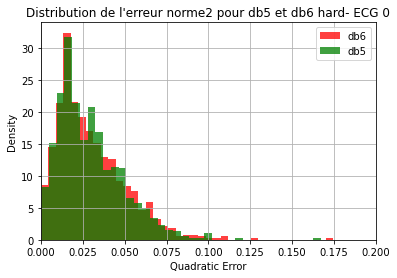

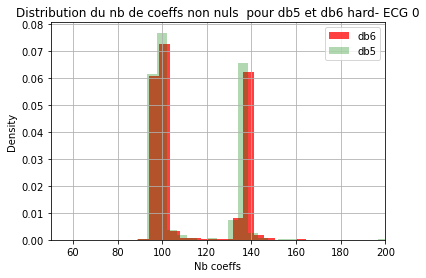

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 110.36it/s]


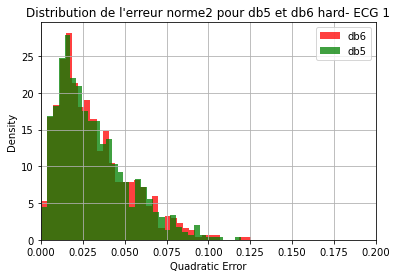

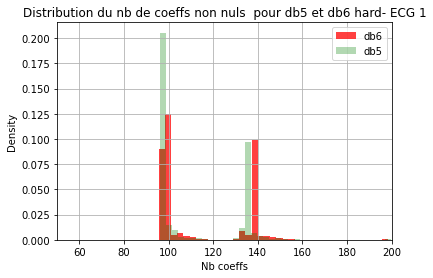

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 107.20it/s]


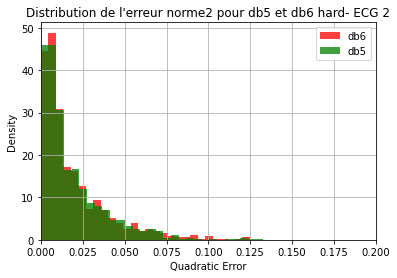

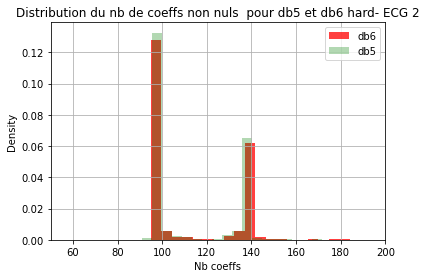

In [81]:
for TYPE_ECG in range(3):

    error_db5, nb_non_zero_db5=distribution_error_and_count_zero(TYPE_ECG,'db5',5,'hard',1)
    error_db6, nb_non_zero_db6=distribution_error_and_count_zero(TYPE_ECG,'db6',5,'hard',1)
    
    n2, bins2, patches2 = plt.hist(error_db6, bins=100,density=True, facecolor='r', alpha=0.75, label='db6')
    n, bins, patches = plt.hist(error_db5, bins=100,density=True, facecolor='g', alpha=0.75, label='db5')

    plt.xlabel('Quadratic Error')
    plt.ylabel('Density')
    plt.title("Distribution de l'erreur norme2 pour db5 et db6 hard- ECG "+str(TYPE_ECG))
    plt.xlim(0, 0.2)
    plt.legend()
    plt.grid(True)
    plt.show()

    n2, bins2, patches2 = plt.hist(nb_non_zero_db6, bins=100,density=True, facecolor='r', alpha=0.75, label='db6')
    n, bins, patches = plt.hist(nb_non_zero_db5, bins=100,density=True, facecolor='g', alpha=0.3, label='db5')

    plt.xlabel('Nb coeffs')
    plt.ylabel('Density')
    plt.title("Distribution du nb de coeffs non nuls  pour db5 et db6 hard- ECG "+str(TYPE_ECG))
    plt.xlim(50, 200)
    plt.legend()
    plt.grid(True)
    plt.show()

Symlet 7 or 8 ?

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 105.88it/s]


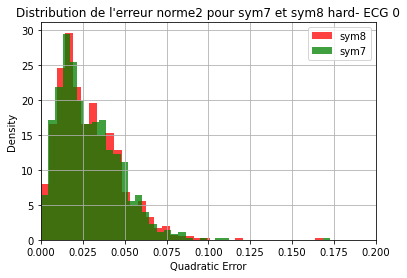

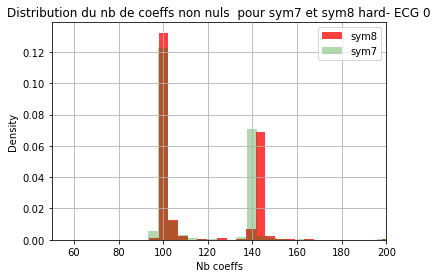

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 106.82it/s]


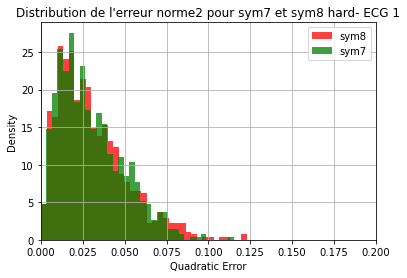

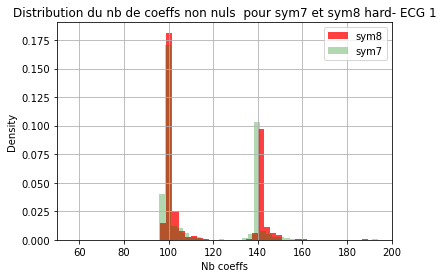

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 104.65it/s]


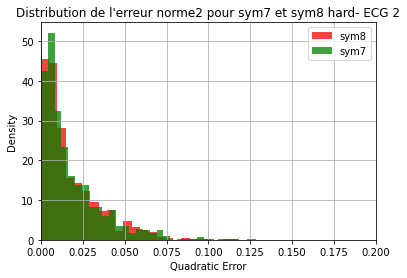

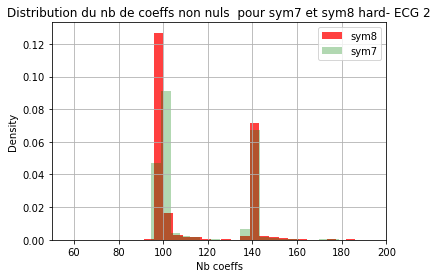

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 106.79it/s]


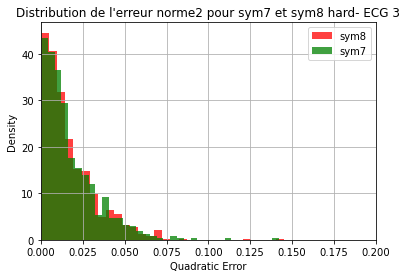

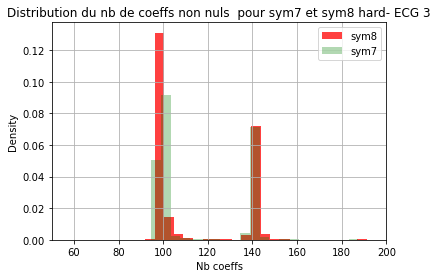

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 112.08it/s]


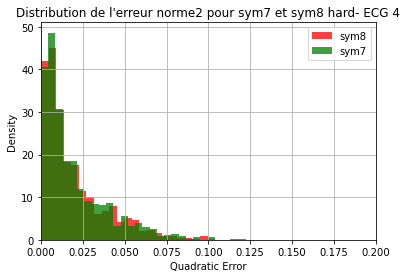

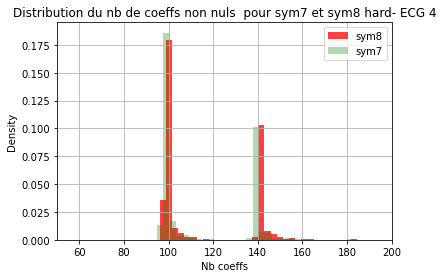

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 110.02it/s]


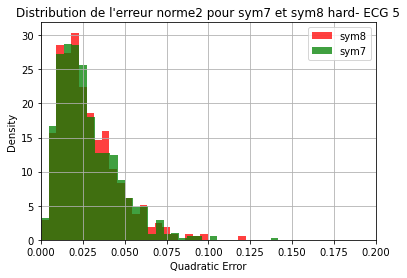

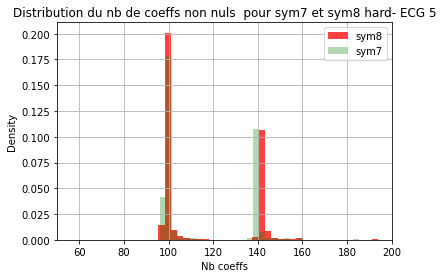

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 110.54it/s]


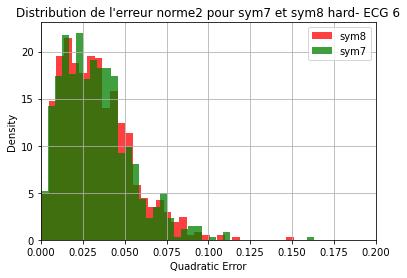

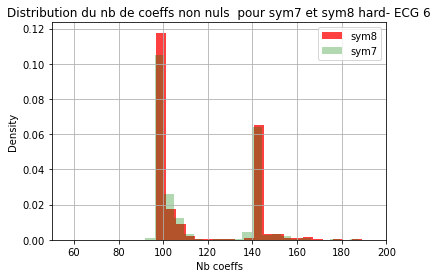

100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [00:08<00:00, 95.41it/s]


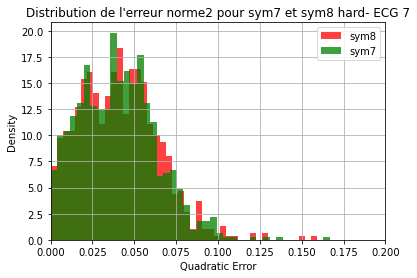

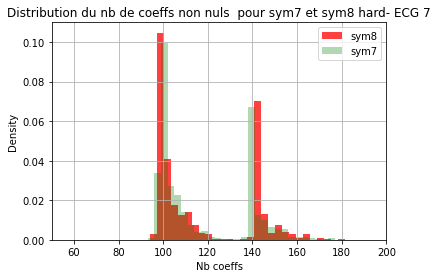

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 111.11it/s]


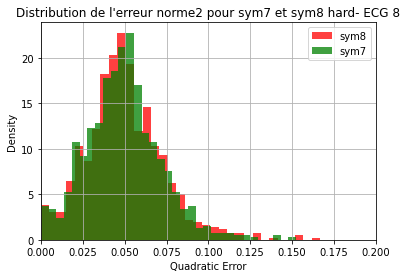

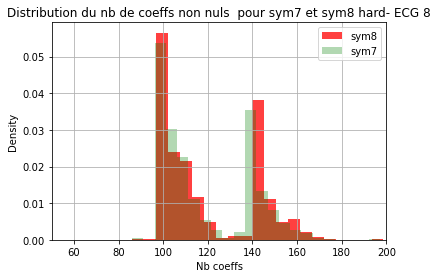

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 110.77it/s]


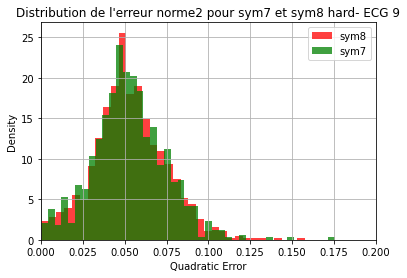

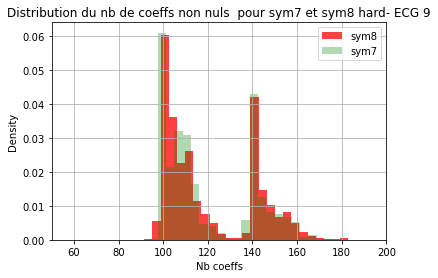

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 110.32it/s]


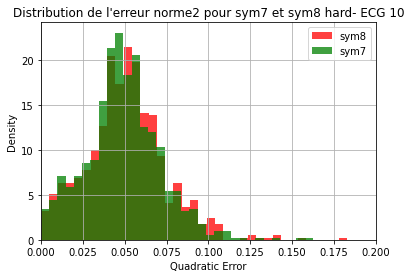

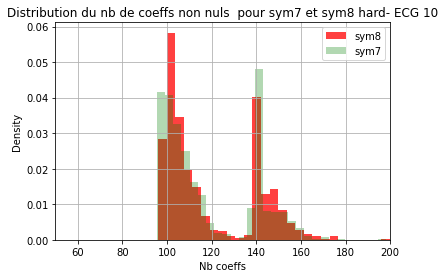

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 110.59it/s]


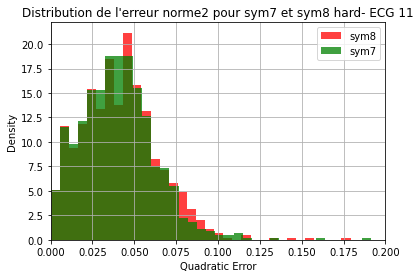

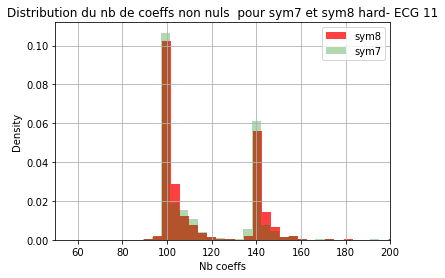

In [83]:
for TYPE_ECG in range(12):

    error_sym7, nb_non_zero_sym7=distribution_error_and_count_zero(TYPE_ECG,'sym7',5,'hard',1)
    error_sym8, nb_non_zero_sym8=distribution_error_and_count_zero(TYPE_ECG,'sym8',5,'hard',1)
    
    n2, bins2, patches2 = plt.hist(error_sym8, bins=100,density=True, facecolor='r', alpha=0.75, label='sym8')
    n, bins, patches = plt.hist(error_sym7, bins=100,density=True, facecolor='g', alpha=0.75, label='sym7')

    plt.xlabel('Quadratic Error')
    plt.ylabel('Density')
    plt.title("Distribution de l'erreur norme2 pour sym7 et sym8 hard- ECG "+str(TYPE_ECG))
    plt.xlim(0, 0.2)
    plt.legend()
    plt.grid(True)
    plt.show()

    n2, bins2, patches2 = plt.hist(nb_non_zero_sym8, bins=100,density=True, facecolor='r', alpha=0.75, label='sym8')
    n, bins, patches = plt.hist(nb_non_zero_sym7, bins=100,density=True, facecolor='g', alpha=0.3, label='sym7')

    plt.xlabel('Nb coeffs')
    plt.ylabel('Density')
    plt.title("Distribution du nb de coeffs non nuls  pour sym7 et sym8 hard- ECG "+str(TYPE_ECG))
    plt.xlim(50, 200)
    plt.legend()
    plt.grid(True)
    plt.show()

Sym7 or db6 ?

100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [00:08<00:00, 93.60it/s]


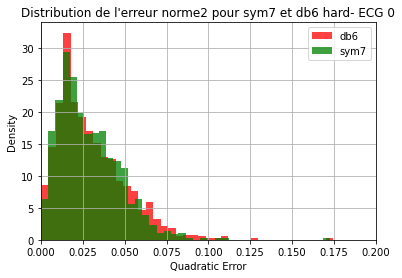

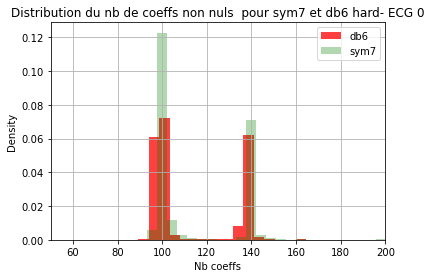

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 111.04it/s]


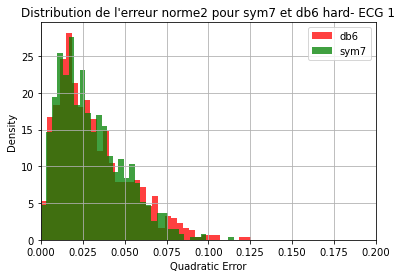

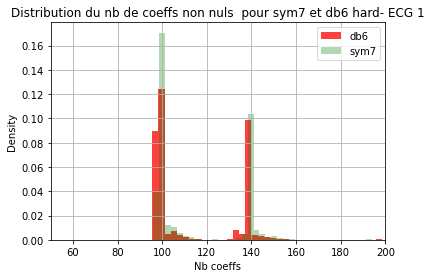

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 113.72it/s]


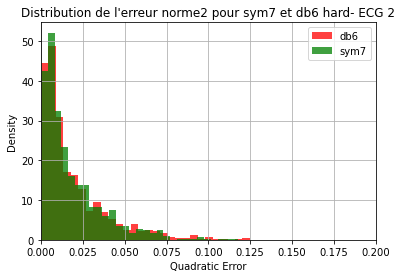

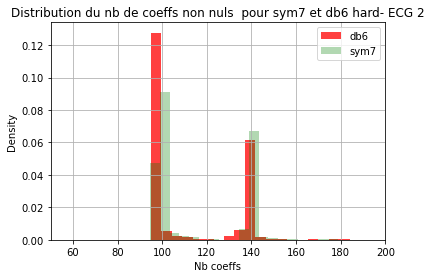

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 114.03it/s]


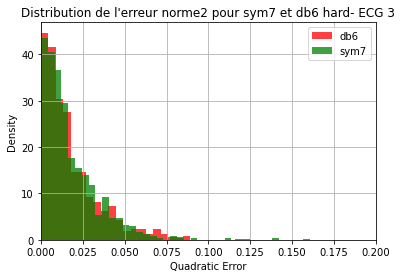

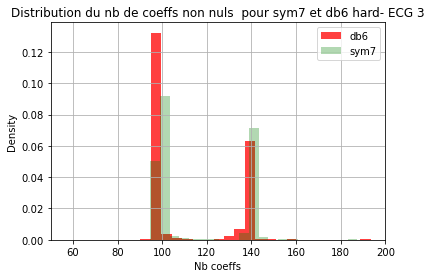

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 115.46it/s]


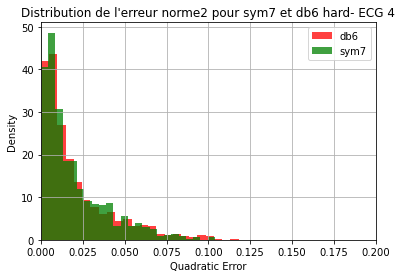

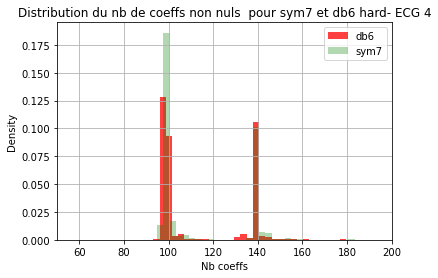

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 105.15it/s]


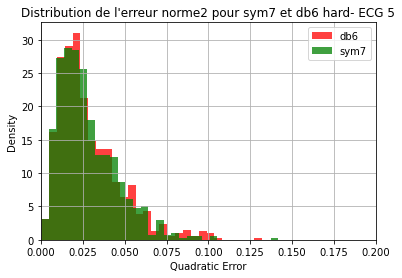

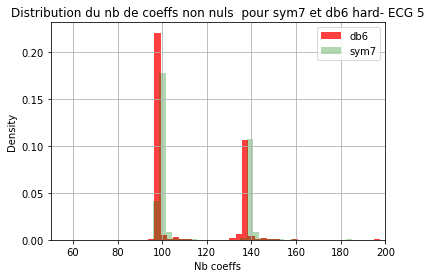

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 110.39it/s]


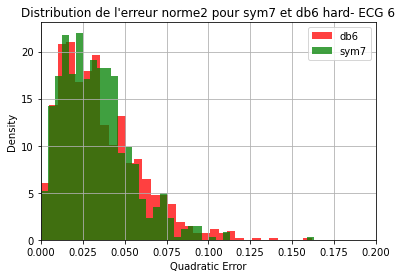

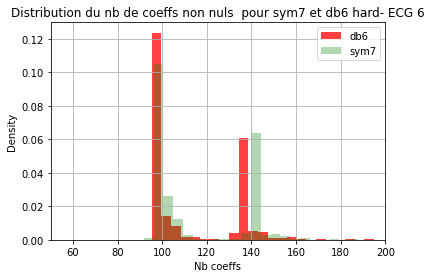

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 106.79it/s]


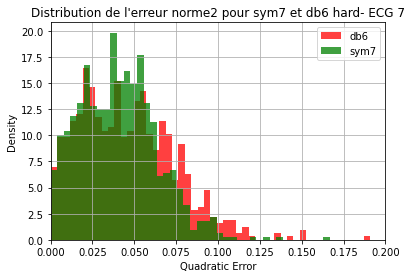

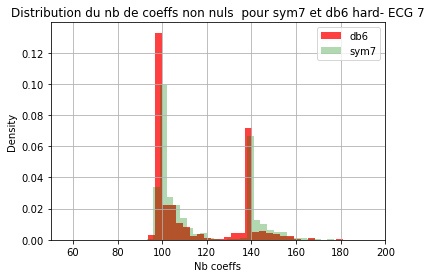

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 109.32it/s]


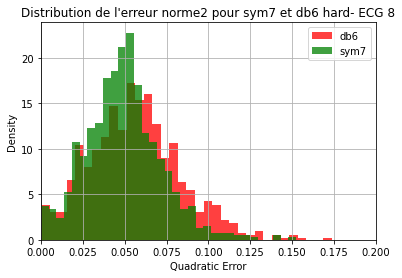

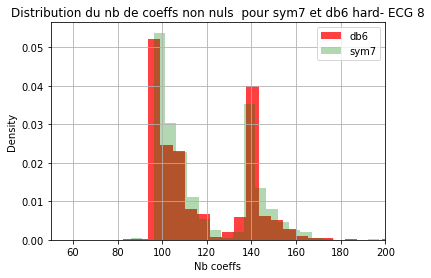

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 109.30it/s]


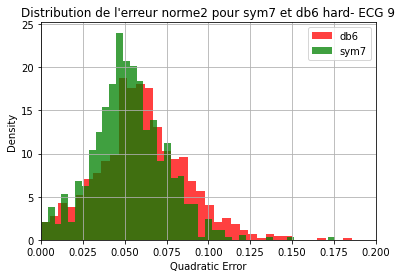

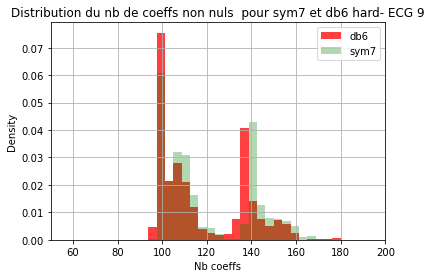

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 108.40it/s]


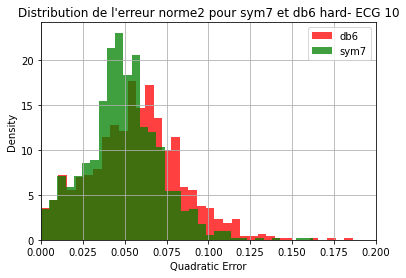

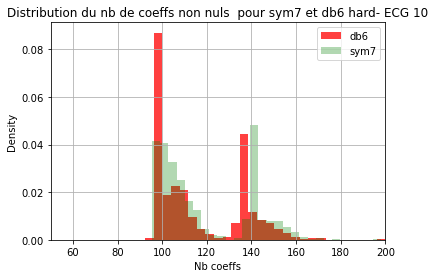

100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [00:15<00:00, 53.74it/s]


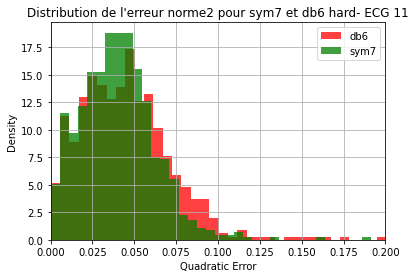

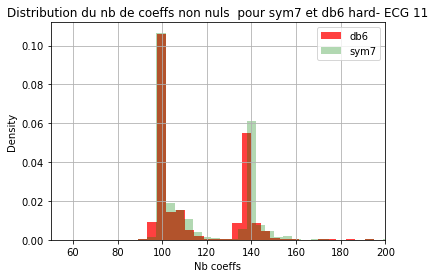

In [85]:
for TYPE_ECG in range(12):

    error_sym7, nb_non_zero_sym7=distribution_error_and_count_zero(TYPE_ECG,'sym7',5,'hard',1)
    error_db6, nb_non_zero_db6=distribution_error_and_count_zero(TYPE_ECG,'db6',5,'hard',1)
    
    n2, bins2, patches2 = plt.hist(error_db6, bins=100,density=True, facecolor='r', alpha=0.75, label='db6')
    n, bins, patches = plt.hist(error_sym7, bins=100,density=True, facecolor='g', alpha=0.75, label='sym7')

    plt.xlabel('Quadratic Error')
    plt.ylabel('Density')
    plt.title("Distribution de l'erreur norme2 pour sym7 et db6 hard- ECG "+str(TYPE_ECG))
    plt.xlim(0, 0.2)
    plt.legend()
    plt.grid(True)
    plt.show()

    n2, bins2, patches2 = plt.hist(nb_non_zero_db6, bins=100,density=True, facecolor='r', alpha=0.75, label='db6')
    n, bins, patches = plt.hist(nb_non_zero_sym7, bins=100,density=True, facecolor='g', alpha=0.3, label='sym7')

    plt.xlabel('Nb coeffs')
    plt.ylabel('Density')
    plt.title("Distribution du nb de coeffs non nuls  pour sym7 et db6 hard- ECG "+str(TYPE_ECG))
    plt.xlim(50, 200)
    plt.legend()
    plt.grid(True)
    plt.show()

# Exploration des coefficients

In [8]:
FAMILY='sym7'
SIGMA=1
LEVEL=5
TYPE_THRE='hard'

TYPE_ECG=0

threshold_coeff=0.01

all_coeffs : taille 827 x 6 x taille variable

## Plot de chaque famille de coeffs sur tous les ECG 0

Etude la moyenne de chaque coefficient d'ondelette sur les 5 familles

In [143]:
a=np.array([1,2,3,4])
a[a<3]=0
a

array([0, 0, 3, 4])

In [21]:
def plot_threshold_coeffs(type_ecg=TYPE_ECG,threshold_coeff=0.01):  
    all_coeffs=np.array([get_coeff_multi_level(table_ecg[patient_id,:,type_ecg],SIGMA,TYPE_THRE,FAMILY,level=LEVEL) for patient_id in range(NB_PATIENT)])
    nb_total_coeffs_non_zero_before=0
    nb_total_coeffs_non_zero_after=0
    for i in range(1,6):
        abs_mean=np.abs(np.mean(all_coeffs[:,i]))
        new_abs_mean=np.copy(abs_mean)
        new_abs_mean[new_abs_mean<threshold_coeff]=0
        plt.plot(abs_mean, label='coeffs perdus')
        plt.plot(new_abs_mean)
        plt.xlabel('Indice des coefficients')
        plt.ylabel('|Moyenne| sur tous les ECG')
        plt.title('Niveau de décomposition ' +str(5-i+1))
        plt.legend()
        plt.show()
        zero_before=np.sum(abs_mean>0.0001)
        nb_total_coeffs_non_zero_before+=zero_before
        zero_after=np.sum(new_abs_mean>0.001)
        nb_total_coeffs_non_zero_after+=zero_after

        print("Nb de coeffs non nuls avant = ", zero_before)
        print("Nb de coeffs non nuls après = ", zero_after)
        print("Perte = ",(zero_after - zero_before)/zero_before )

    print("Nb total de coeffs non nuls avant = ", nb_total_coeffs_non_zero_before)
    print("Nb total de coeffs non nuls après = ", nb_total_coeffs_non_zero_after)
    print("Perte = ",(nb_total_coeffs_non_zero_after - nb_total_coeffs_non_zero_before)/nb_total_coeffs_non_zero_before )

C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


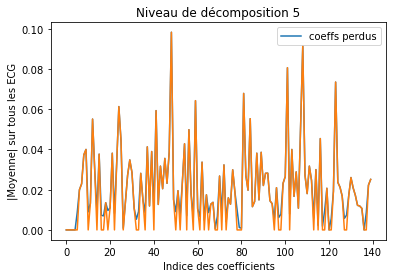

Nb de coeffs non nuls avant =  133
Nb de coeffs non nuls après =  95
Perte =  -0.2857142857142857


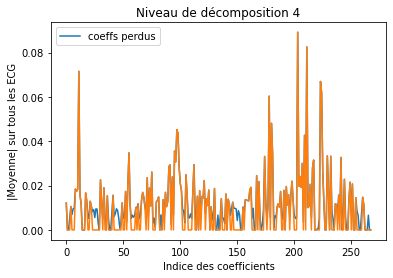

Nb de coeffs non nuls avant =  227
Nb de coeffs non nuls après =  124
Perte =  -0.45374449339207046


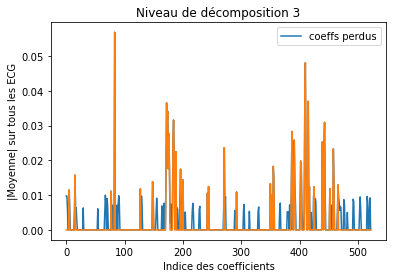

Nb de coeffs non nuls avant =  147
Nb de coeffs non nuls après =  50
Perte =  -0.6598639455782312


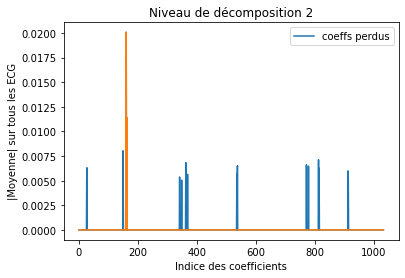

Nb de coeffs non nuls avant =  19
Nb de coeffs non nuls après =  3
Perte =  -0.8421052631578947


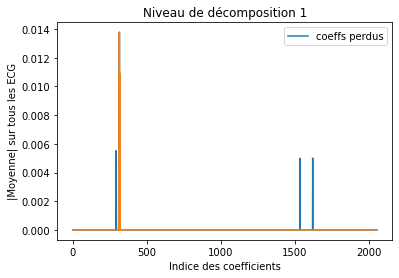

Nb de coeffs non nuls avant =  9
Nb de coeffs non nuls après =  2
Perte =  -0.7777777777777778
Nb total de coeffs non nuls avant =  535
Nb total de coeffs non nuls après =  274
Perte =  -0.48785046728971965


In [22]:
plot_threshold_coeffs(0,threshold_coeff=0.01)

C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


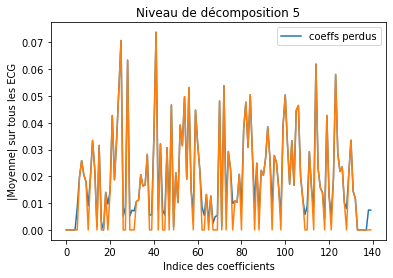

Nb de coeffs non nuls avant =  129
Nb de coeffs non nuls après =  89
Perte =  -0.31007751937984496


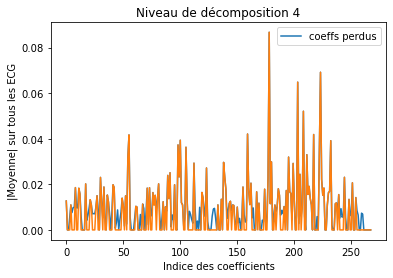

Nb de coeffs non nuls avant =  213
Nb de coeffs non nuls après =  108
Perte =  -0.49295774647887325


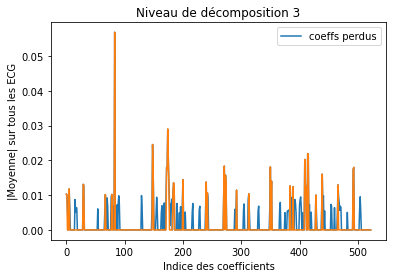

Nb de coeffs non nuls avant =  141
Nb de coeffs non nuls après =  41
Perte =  -0.7092198581560284


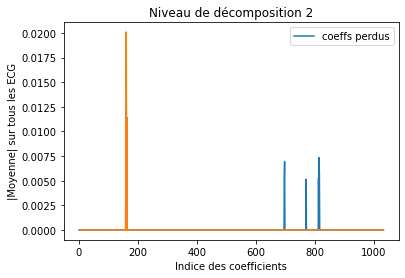

Nb de coeffs non nuls avant =  9
Nb de coeffs non nuls après =  3
Perte =  -0.6666666666666666


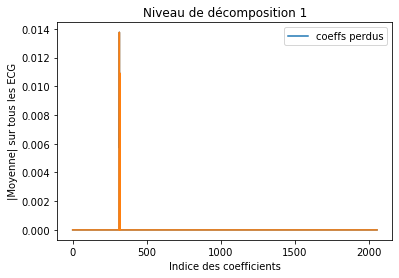

Nb de coeffs non nuls avant =  5
Nb de coeffs non nuls après =  2
Perte =  -0.6
Nb total de coeffs non nuls avant =  497
Nb total de coeffs non nuls après =  243
Perte =  -0.5110663983903421


In [161]:
plot_threshold_coeffs(2,threshold_coeff=0.01)

In [10]:
def gain_threshold_coeffs(threshold_coeff=0.01):
    final_nb_total_coeffs_non_zero_before=0
    final_nb_total_coeffs_non_zero_after=0
    for i in range(1,6):
        type_non_zero_before=[]
        type_non_zero_after=[]
        gain_total=[]
        for type_ecg in range(12):
            all_coeffs=np.array([get_coeff_multi_level(table_ecg[patient_id,:,type_ecg],SIGMA,TYPE_THRE,FAMILY,level=LEVEL) for patient_id in range(NB_PATIENT)])
            nb_total_coeffs_non_zero_before=0
            nb_total_coeffs_non_zero_after=0
            
            abs_mean=np.abs(np.mean(all_coeffs[:,i]))
            new_abs_mean=np.copy(abs_mean)
            new_abs_mean[new_abs_mean<threshold_coeff]=0
            
            zero_before=np.sum(abs_mean>0.0001)
            zero_after=np.sum(new_abs_mean>0.001)
            
            type_non_zero_before.append(zero_before)
            type_non_zero_after.append(zero_after)
            gain_total.append((zero_after-zero_before)/zero_before)
        final_nb_total_coeffs_non_zero_before+=np.mean(type_non_zero_before)
        final_nb_total_coeffs_non_zero_after+=np.mean(type_non_zero_after)
        plt.plot(type_non_zero_before, label='before', color='green')
        plt.plot(type_non_zero_after, label='after', color='red')
        plt.xlabel('Type_ecg')
        plt.title('Moyenne du nb de coeffs non nuls =f(ECG), niveau '+str(5-i+1))
        plt.legend()
        plt.show()
        
        plt.plot(np.abs(gain_total), color='blue')
        plt.xlabel('Type_ecg')
        plt.title('Perte du nb de coeffs non nuls =f(ECG), niveau '+str(5-i+1))
        plt.show()
        print("----------------------------------------------------------------------------------------------------")
    print("Nb de coeffs non nuls avant en moyenne = ", final_nb_total_coeffs_non_zero_before)
    print("Nb de coeffs non nuls après en moyenne = ", final_nb_total_coeffs_non_zero_after)

C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


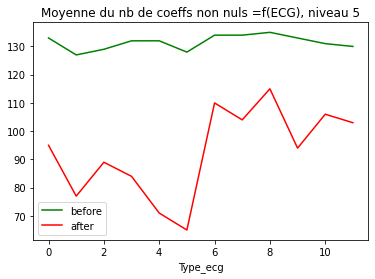

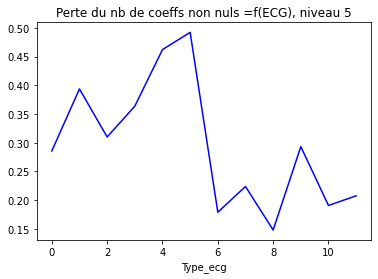

----------------------------------------------------------------------------------------------------


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


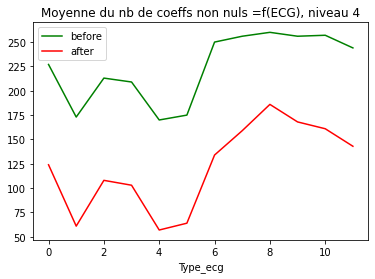

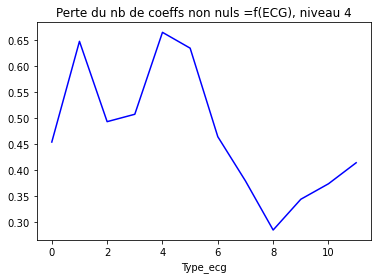

----------------------------------------------------------------------------------------------------


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


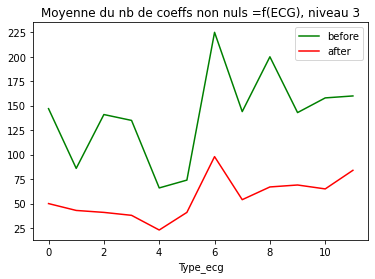

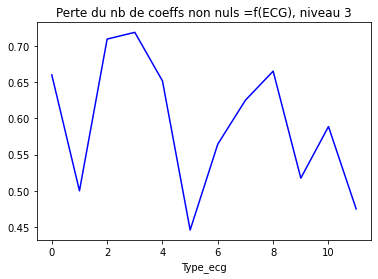

----------------------------------------------------------------------------------------------------


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


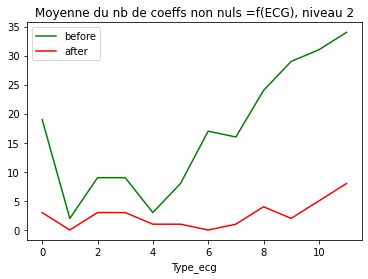

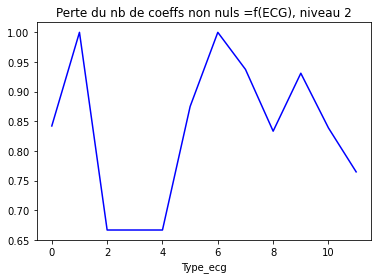

----------------------------------------------------------------------------------------------------


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


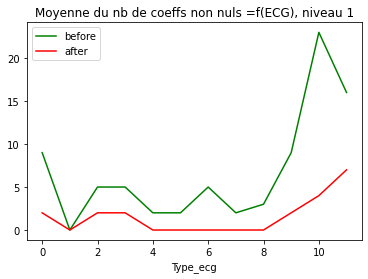

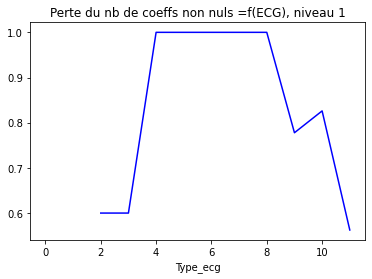

----------------------------------------------------------------------------------------------------
Nb de coeffs non nuls avant en moyenne =  519.0833333333333
Nb de coeffs non nuls après en moyenne =  275.33333333333326


In [174]:
gain_threshold_coeffs(threshold_coeff=0.01)

In [11]:
def get_indices_list_below_threshold(type_ecg=TYPE_ECG,threshold_coeff=0.01):
    all_coeffs=np.array([get_coeff_multi_level(table_ecg[patient_id,:,type_ecg],SIGMA,TYPE_THRE,FAMILY,level=LEVEL) for patient_id in range(NB_PATIENT)])
    liste_indices=[]
    for i in range(1,6):
        abs_mean=np.abs(np.mean(all_coeffs[:,i]))
        liste_indices.append(np.where(abs_mean<threshold_coeff))
    return liste_indices

In [186]:
get_indices_list_below_threshold()

C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


[(array([  0,   1,   2,   3,   4,   5,  10,  14,  16,  17,  19,  22,  26,
          32,  33,  36,  40,  50,  52,  55,  58,  61,  63,  65,  68,  69,
          71,  73,  78,  79,  80,  95,  97,  98, 102, 113, 115, 117, 118,
         120, 121, 127, 128, 136, 137], dtype=int64),),
 (array([  1,   2,   3,   5,   6,   7,  14,  15,  16,  19,  20,  23,  24,
          25,  26,  27,  28,  29,  32,  34,  35,  37,  38,  39,  40,  42,
          43,  44,  45,  46,  47,  48,  50,  51,  53,  57,  58,  59,  60,
          62,  64,  65,  70,  72,  76,  77,  78,  82,  83,  84,  86,  92,
          94, 102, 103, 104, 107, 108, 109, 110, 113, 114, 116, 118, 122,
         126, 128, 129, 131, 132, 133, 134, 135, 137, 138, 139, 141, 144,
         145, 147, 148, 149, 150, 151, 152, 153, 154, 156, 163, 164, 165,
         166, 168, 170, 171, 172, 173, 176, 179, 182, 183, 184, 189, 190,
         192, 196, 200, 201, 202, 208, 210, 215, 218, 219, 220, 221, 222,
         227, 228, 231, 233, 234, 235, 238, 240, 242, 24

In [12]:
def distribution_error_without_threshold(type_ecg=TYPE_ECG):
    error_range=[]
    for patient_id in range(NB_PATIENT):
        ecg=table_ecg[patient_id,:,type_ecg]
        coeffs=get_coeff_multi_level(ecg,SIGMA,TYPE_THRE,FAMILY,level=LEVEL)
        
        #error without common threshold
        error_signal=error(ecg,reconstruct_signal(coeffs, FAMILY))
        error_range.append(error_signal)
    return error_range

def distribution_error_below_threshold(type_ecg=TYPE_ECG,threshold_coeff=0.01):
    error_range_thre=[]
    for patient_id in tqdm(range(NB_PATIENT)):
        ecg=table_ecg[patient_id,:,type_ecg]
        coeffs=get_coeff_multi_level(ecg,SIGMA,TYPE_THRE,FAMILY,level=LEVEL)
        
        #error with threshold
        liste_indices_1_5=get_indices_list_below_threshold(type_ecg, threshold_coeff)
        for i in range(1,6):
            coeffs[i][liste_indices_1_5[i-1]]=0
        error_signal_thre=error(ecg,reconstruct_signal(coeffs, FAMILY))
        error_range_thre.append(error_signal_thre)
    return error_range_thre

  0%|                                                                                          | 0/827 [00:00<?, ?it/s]C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [04:38<00:00,  2.97it/s]


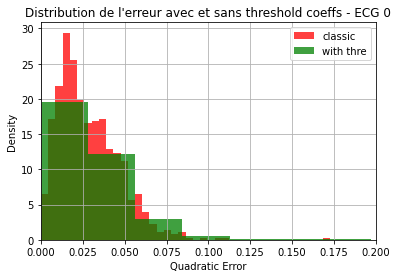

In [193]:
error, error_thre=distribution_error_below_threshold()
n2, bins2, patches2 = plt.hist(error, bins=200,density=True, facecolor='r', alpha=0.75, label='classic')
n, bins, patches = plt.hist(error_thre, bins=200,density=True, facecolor='g', alpha=0.75, label='with thre')

plt.xlabel('Quadratic Error')
plt.ylabel('Density')
plt.title("Distribution de l'erreur avec et sans threshold coeffs - ECG "+str(TYPE_ECG))
plt.xlim(0, 0.2)
plt.legend()
plt.grid(True)
plt.show()

  0%|                                                                                          | 0/827 [00:00<?, ?it/s]

threshold_coeff = 0.02


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [04:53<00:00,  2.82it/s]


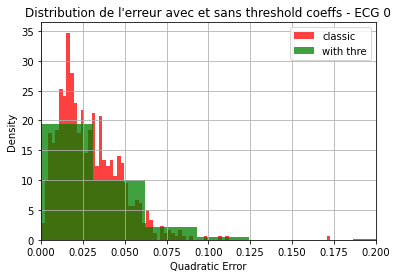

In [203]:
print("threshold_coeff =", 0.02)
error_class, error_thre=distribution_error_below_threshold(threshold_coeff=0.02)


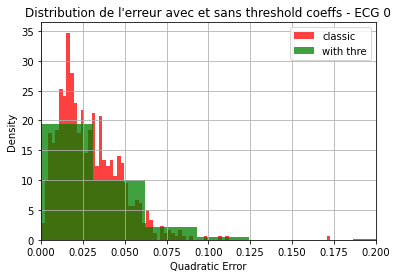

In [206]:
n2, bins2, patches2 = plt.hist(error_class, bins=200,density=True, facecolor='r', alpha=0.75, label='classic')
n, bins, patches = plt.hist(error_thre, bins=200,density=True, facecolor='g', alpha=0.75, label='with thre')

plt.xlabel('Quadratic Error')
plt.ylabel('Density')
plt.title("Distribution de l'erreur avec et sans threshold coeffs - ECG "+str(TYPE_ECG))
plt.xlim(0, 0.2)
plt.legend()
plt.grid(True)
plt.show()

In [207]:
print("threshold_coeff =", 0.03)
error_class, error_thre=distribution_error_below_threshold(threshold_coeff=0.03)

  0%|                                                                                          | 0/827 [00:00<?, ?it/s]

threshold_coeff = 0.03


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [04:57<00:00,  2.78it/s]


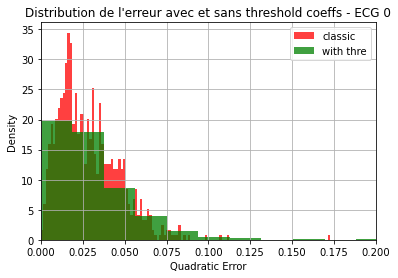

In [211]:
n2, bins2, patches2 = plt.hist(error_class, bins=300,density=True, facecolor='r', alpha=0.75, label='classic')
n, bins, patches = plt.hist(error_thre, bins=300,density=True, facecolor='g', alpha=0.75, label='with thre')

plt.xlabel('Quadratic Error')
plt.ylabel('Density')
plt.title("Distribution de l'erreur avec et sans threshold coeffs - ECG "+str(TYPE_ECG))
plt.xlim(0, 0.2)
plt.legend()
plt.grid(True)
plt.show()

In [213]:
print("threshold_coeff =", 0.04)
error_class, error_thre=distribution_error_below_threshold(threshold_coeff=0.04)
print("moyenne error : ", np.mean(error_class))
print("moyenne error with threshold :", np.mean(error_thre))

  0%|                                                                                          | 0/827 [00:00<?, ?it/s]

threshold_coeff = 0.04


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [05:15<00:00,  2.62it/s]

moyenne error :  0.029687111745177013
moyenne error with threshold : 0.057119620489991224


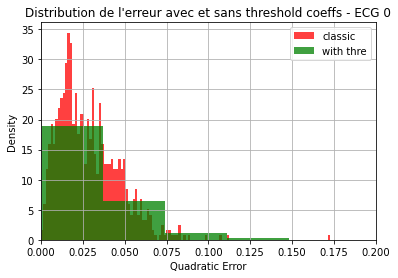

In [214]:
n2, bins2, patches2 = plt.hist(error_class, bins=300,density=True, facecolor='r', alpha=0.75, label='classic')
n, bins, patches = plt.hist(error_thre, bins=300,density=True, facecolor='g', alpha=0.75, label='with thre')

plt.xlabel('Quadratic Error')
plt.ylabel('Density')
plt.title("Distribution de l'erreur avec et sans threshold coeffs - ECG "+str(TYPE_ECG))
plt.xlim(0, 0.2)
plt.legend()
plt.grid(True)
plt.show()

In [216]:
print("threshold_coeff =", 0.05)
error_class, error_thre=distribution_error_below_threshold(threshold_coeff=0.05)
print("moyenne error : ", np.mean(error_class))
print("moyenne error with threshold :", np.mean(error_thre))

  0%|                                                                                          | 0/827 [00:00<?, ?it/s]

threshold_coeff = 0.05


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [06:09<00:00,  2.24it/s]

moyenne error :  0.029687111745177013
moyenne error with threshold : 0.05996532657170391


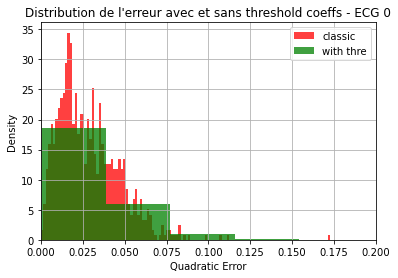

In [217]:
n2, bins2, patches2 = plt.hist(error_class, bins=300,density=True, facecolor='r', alpha=0.75, label='classic')
n, bins, patches = plt.hist(error_thre, bins=300,density=True, facecolor='g', alpha=0.75, label='with thre')

plt.xlabel('Quadratic Error')
plt.ylabel('Density')
plt.title("Distribution de l'erreur avec et sans threshold coeffs - ECG "+str(TYPE_ECG))
plt.xlim(0, 0.2)
plt.legend()
plt.grid(True)
plt.show()

In [221]:
print("threshold_coeff =", 0.08)
error_class, error_thre=distribution_error_below_threshold(threshold_coeff=0.08)
print("moyenne error : ", np.mean(error_class))
print("moyenne error with threshold :", np.mean(error_thre))

  0%|                                                                                          | 0/827 [00:00<?, ?it/s]

threshold_coeff = 0.08


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [05:35<00:00,  2.46it/s]

moyenne error :  0.029687111745177013
moyenne error with threshold : 0.06656685296509009


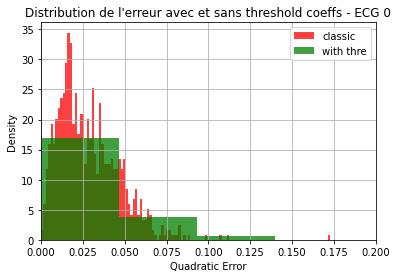

In [224]:
n2, bins2, patches2 = plt.hist(error_class, bins=300,density=True, facecolor='r', alpha=0.75, label='classic')
n, bins, patches = plt.hist(error_thre, bins=300,density=True, facecolor='g', alpha=0.75, label='with thre')

plt.xlabel('Quadratic Error')
plt.ylabel('Density')
plt.title("Distribution de l'erreur avec et sans threshold coeffs - ECG "+str(TYPE_ECG))
plt.xlim(0, 0.2)
plt.legend()
plt.grid(True)
plt.show()

In [242]:
threshold_space=np.linspace(0.,0.1,20)

true_error=[]
mean_ecg=[]
std_ecg=[]

for type_ecg in range(12):
    error_range=distribution_error_without_threshold(type_ecg)
    true_error.append([np.mean(error_range)]*len(threshold_space))

    mean_error_thre=[]
    std_error_thre=[]

    for threshold_coeff in threshold_space:
        error_range_thre=distribution_error_below_threshold(type_ecg, threshold_coeff)
        mean_error_thre.append(np.mean(error_range_thre))
        std_error_thre.append(np.var(error_range_thre))
    mean_error_thre=np.array(mean_error_thre)
    mean_ecg.append(mean_error_thre)
    std_error_thre=np.array(std_error_thre)
    std_ecg.append(std_error_thre)

  0%|                                                                                          | 0/827 [00:00<?, ?it/s]C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [02:05<00:00,  6.59it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 827/827 [02:01<00:00,  6.82it/s]


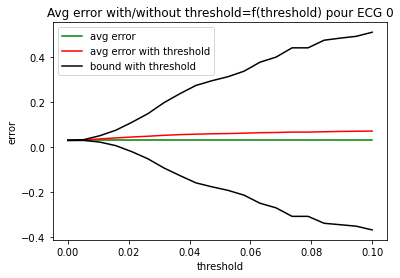

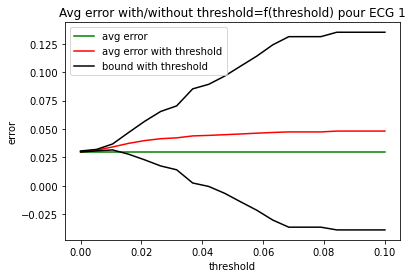

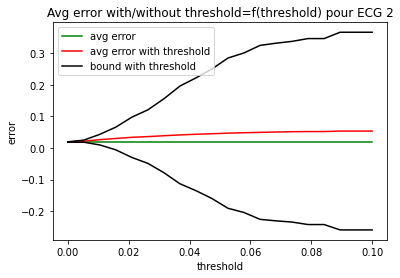

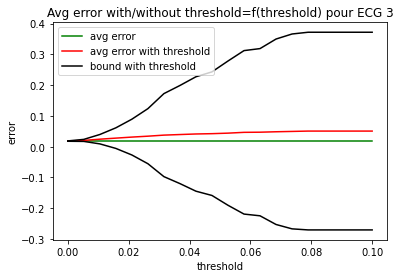

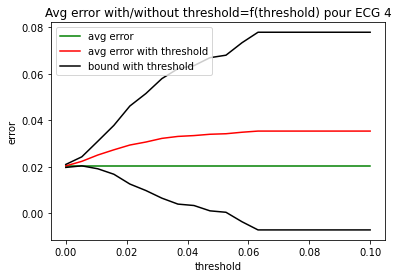

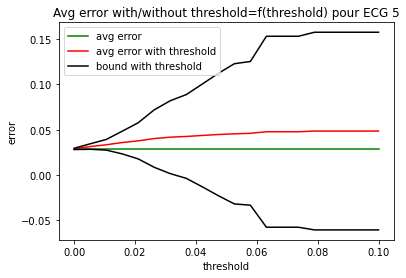

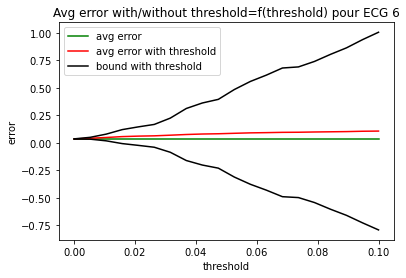

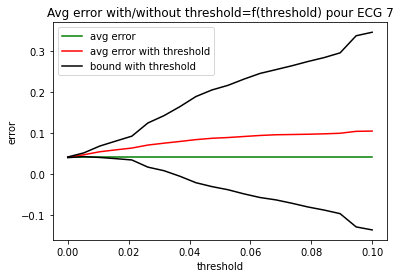

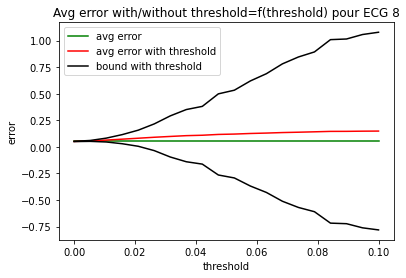

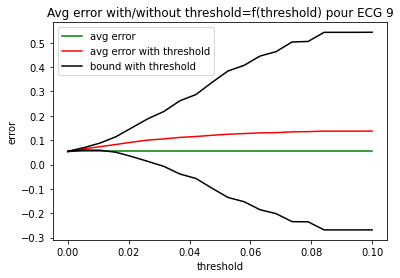

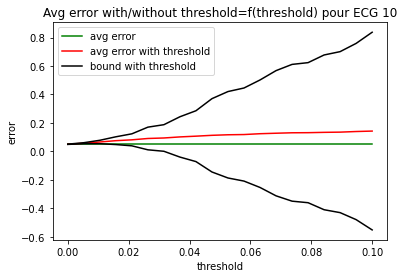

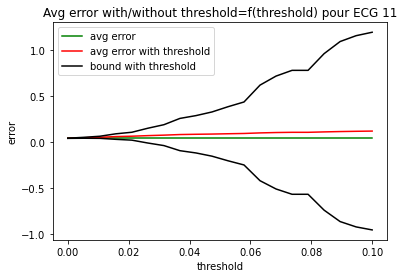

In [244]:
for i in range(12):
    plt.plot(threshold_space,true_error[i], label='avg error', color='green')
    plt.plot(threshold_space,mean_ecg[i], label='avg error with threshold', color='red')
    plt.plot(threshold_space,mean_ecg[i]-std_ecg[i], label='bound with threshold', color='black')
    plt.plot(threshold_space,mean_ecg[i]+std_ecg[i], color='black')
    plt.title("Avg error with/without threshold=f(threshold) pour ECG "+str(i))
    plt.legend()
    plt.xlabel("threshold")
    plt.ylabel("error")
    plt.show()

In [251]:
import matplotlib.colors as col
colorNames = list(col.cnames.keys())
colorNames

['aliceblue',
 'antiquewhite',
 'aqua',
 'aquamarine',
 'azure',
 'beige',
 'bisque',
 'black',
 'blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgreen',
 'darkgrey',
 'darkkhaki',
 'darkmagenta',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darkred',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'darkslategrey',
 'darkturquoise',
 'darkviolet',
 'deeppink',
 'deepskyblue',
 'dimgray',
 'dimgrey',
 'dodgerblue',
 'firebrick',
 'floralwhite',
 'forestgreen',
 'fuchsia',
 'gainsboro',
 'ghostwhite',
 'gold',
 'goldenrod',
 'gray',
 'green',
 'greenyellow',
 'grey',
 'honeydew',
 'hotpink',
 'indianred',
 'indigo',
 'ivory',
 'khaki',
 'lavender',
 'lavenderblush',
 'lawngreen',
 'lemonchiffon',
 'lightblue',
 'lightcoral',
 'lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 

In [1]:
fig, ax1=plt.subplots(1,1,sharex=True,figsize=(25,10))

couleurs = ['b', 'g', 'r', 'c', 'm', 'y', 'k','brown', 'darkgrey','deepskyblue', 'firebrick','lime' ]

for i in range(12):
    ax1.plot(threshold_space,true_error[i], label='avg error ECG'+str(i), color=couleurs[i])
    ax1.plot(threshold_space,mean_ecg[i],'--', label='avg error with threshold ECG'+str(i), color=couleurs[i])
   # plt.plot(threshold_space,mean_ecg[i]-std_ecg[i], label='bound with threshold', color='black')
    #plt.plot(threshold_space,mean_ecg[i]+std_ecg[i], color='black')
ax1.set_title("Avg error with/without threshold=f(threshold)")
ax1.legend()
ax1.grid()
#ax1.xlabel("threshold")
#ax1.ylabel("error")
plt.show()

NameError: name 'plt' is not defined

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.]), array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,

C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


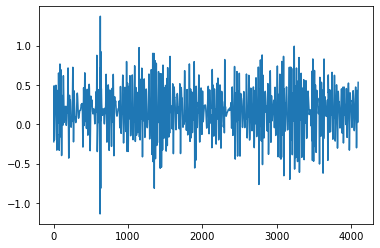

C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [44]:
#On fixe threshold_coeff à 0.01

TYPE_ECG=0
THRESHOLD_COEFF=0.01
sigma=1

DIC_SIZE_WAVELET={0:140,
                 1 : 140,
                 2 :268,
                 3 : 523,
                 4 : 1033,
                 5 : 2054}

#fonctions pour le process

#1 : liste_coeffs d'un ECG -> format de coeffs pywt avec les 0 aux bon endroit
get_coeff_multi_level(table_ecg[0,:,0],SIGMA,TYPE_THRE,FAMILY,level=LEVEL)

def get_indices_list_above_threshold(type_ecg=TYPE_ECG,threshold_coeff=THRESHOLD_COEFF):
    """ Returns the indices of the coeffs with avg(abs)>threshold
    format : list of arrays
    """
    all_coeffs=np.array([get_coeff_multi_level(table_ecg[patient_id,:,type_ecg],SIGMA,TYPE_THRE,FAMILY,level=LEVEL) for patient_id in range(NB_PATIENT)])
    liste_indices=[]
    for i in range(1,6):
        abs_mean=np.abs(np.mean(all_coeffs[:,i]))
        liste_indices.append(np.where(abs_mean>=threshold_coeff))
    return liste_indices

def from_array_coeffs_to_coeffs_with_zeros(array_coeffs, liste_indices_non_zero):
    """ Returns the list of wavelet coeffs with threshold applied : 
        - array_coeffs = np.array(140 + taille coeffs non nuls ecg après threshold)
        - liste_indices_non_zero = obtenu avec get_indices_list_above threshold
    format : list of arrays
    """
    coeffs_wavelet=[]
    coeffs_wavelet.append(array_coeffs[:DIC_SIZE_WAVELET[0]])
    array_coeffs=array_coeffs[DIC_SIZE_WAVELET[0]:]
    for i in range(1,6):
        array_coeffs_i=np.zeros(DIC_SIZE_WAVELET[i])
        array_coeffs_i[liste_indices_non_zero[i-1]]=array_coeffs[:len(liste_indices_non_zero[i-1][0])]
        array_coeffs=array_coeffs[len(liste_indices_non_zero[i-1][0]):]
        coeffs_wavelet.append(array_coeffs_i)
    return coeffs_wavelet

#2 : from array of coeffs with zeros to signal

    #reconstruct
    
#REVERSE : from signal to array_coeffs

#from ecg to array_coeffs
def from_ecg_to_array_coeffs(ecg, liste_indices_non_zero):
    coeffs=get_coeff_multi_level(ecg,SIGMA,TYPE_THRE,FAMILY,level=LEVEL)
    all_coeffs=[coeffs[0]]
    for i in range(1,6):
        all_coeffs.append(coeffs[i][liste_indices_non_zero[i-1]])
    return np.concatenate(all_coeffs)


liste_indices_non_zero_0=get_indices_list_above_threshold()
long_test=np.sum([len(array[0]) for array in liste_indices_non_zero_0] )

array_coeffs_test=np.ones(long_test+140)
test=from_array_coeffs_to_coeffs_with_zeros(array_coeffs_test, liste_indices_non_zero_0)
print(test)

plt.plot(reconstruct_signal(test, FAMILY))
plt.show()

liste_indices_zero_0=get_indices_list_below_threshold()
from_ecg_to_array_coeffs(table_ecg[20,:,0], liste_indices_non_zero_0)[140:]


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


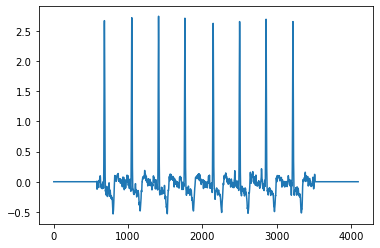

254


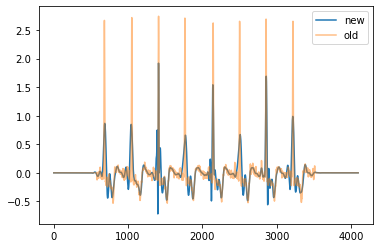

In [155]:
ID=467
TYPE_ECG=11
THRESHOLD_COEFF=0.03

liste_indices_non_zero_0=get_indices_list_above_threshold(type_ecg=TYPE_ECG, threshold_coeff=THRESHOLD_COEFF)

ecg_example=table_ecg[ID,:,TYPE_ECG]

#1
plt.plot(ecg_example)
plt.show()

#2

array_coeffs=from_ecg_to_array_coeffs(ecg_example, liste_indices_non_zero_0)
print(len(array_coeffs))
#print(array_coeffs[140:])

#3

new_signal=reconstruct_signal(from_array_coeffs_to_coeffs_with_zeros(array_coeffs, liste_indices_non_zero_0), FAMILY)
plt.plot(new_signal, label='new')
plt.plot(ecg_example, label='old', alpha=0.5)
plt.legend()
plt.show()




# TRASH

In [180]:
a=np.array([1,2,3,4])
a[np.where(a>2)]=0
a

array([1, 2, 0, 0])

In [57]:
a=np.array([[[0,1],[2,0]],[[3,4],[2,0]]])
b=np.concatenate(a,axis=1)

In [60]:
b

array([[0, 1, 3, 4],
       [2, 0, 2, 0]])

In [59]:
np.sum(np.abs(b)>0.0001,axis=1)

array([3, 2])

In [64]:
CMAP = plt.get_cmap("Set1")

In [65]:
CMAP

In [66]:
import pandas as pd

In [101]:
#confirmation sur une maladie
CMAP = plt.get_cmap("Set1")
DISEASE_DIC = {0: "1dAVb",
               1: "Rien"}
COLOR_DIC = {k: CMAP(k - 2) if k != 0 else CMAP(11) for k, v in DISEASE_DIC.items()}
LABELS = [DISEASE_DIC[c] for c in range(2)]

ANNOTATIONS_CSV=np.genfromtxt("./data/annotations/dnn.csv", delimiter=',')[1:,1:]
ANNOTATIONS_CSV_pd=pd.read_csv("./data/annotations/dnn.csv", delimiter=',')

In [105]:
colors = [COLOR_DIC[y] for y in ANNOTATIONS_CSV_pd["1dAVb"]]

In [96]:
color_1dAVb=[CMAP(11) for value in 

0      0
1      0
2      0
3      0
4      0
      ..
822    0
823    0
824    0
825    0
826    1
Name: 1dAVb, Length: 827, dtype: int64

In [84]:
res=[0,0,1,0,0,0]
colors=[COLOR_DIC[i] for i in range(6) if res[i]>0]

KeyError: 2

In [78]:
ANNOTATIONS_CSV

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [106]:
series={"moyenne":res}
pd.DataFrame(series)

,moyenne
0,0
1,0
2,1
3,0
4,0
5,0


In [138]:
DISEASE_DIC = {0: "Non malade",
               1: "1dAVb",
               2: "RBBB",
               3: "LBBB",
               4: "SB",
               5: "AF",
               6: "ST"
               }
DISEASE_DIC.values()

dict_values(['Non malade', '1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST'])

In [19]:
a=np.array([0,0,0,0,0])
b=np.array([-1,1,0,0,0])

ECG_0=table_ecg[:,:,0]

faux_ecg=[]

def if_zeros(i,j):
    if np.sum(np.abs(ECG_j[i])>0.001)==0:
        faux_ecg.append(i)
        return True
    else:
        return False

ECG_j_prime=[ECG_j[i] for i in range(LEN) if !if_zeros(i)]
y_pred=[y_pred[i] for i in range(LEN) if not i in faux_ecg ]

True
False
